# CLTV Forecast with BG-NBD and Gamma-Gamma

## Business Problem
### FLO would like to set a roadmap for sales and marketing activities. In order for the company to make a medium-long-term plan, it is necessary to estimate the potential value that existing customers will provide to the company in the future

In [1]:
# Step 1: Read the flo_data_20K.csv data.

In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [4]:
df_ = pd.read_csv("flo_data_20k.csv")
df = df_.copy()

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### is null? #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.25, 0.50, 0.75, 0.99, 1]).T)
    print(dataframe.describe().T)


check_df(df)

##################### Shape #####################
(19945, 12)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object
##################### Head #####################
                              master_id order_channel last_order_channel first_order_date last_order_date last_order_date_online last_order_date_offline  order_num_total_ever_online  order_num_total_ever_offline  customer_value_total_ever_offline  customer_value_total_ever_online     

In [6]:
df.shape

(19945, 12)

In [7]:
df.columns

Index(['master_id', 'order_channel', 'last_order_channel', 'first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline', 'order_num_total_ever_online', 'order_num_total_ever_offline', 'customer_value_total_ever_offline', 'customer_value_total_ever_online', 'interested_in_categories_12'], dtype='object')

In [8]:
# master_id = Unique client number
# order_channel = Which channel of the shopping platform is used (Android, iOS, Desktop, Mobile)
# last_order_channel = The channel where the last purchase was made
# first_order_date = Date of the customer's first purchase
# last_order_date = The date of the last purchase made by the customer
# last_order_date_online = The date of the last purchase made by the customer on the online platform
# last_order_date_offline = The date of the last purchase made by the customer on the offline platform
# order_num_total_ever_online = Total number of purchases made by the customer on the online platform
# order_num_total_ever_offline = Total number of purchases made by the customer offline
# customer_value_total_ever_offline = Total price paid by the customer for offline purchases
# customer_value_total_ever_online = Total price paid by the customer for their online shopping
# interested_in_categories_12 = List of categories the customer has purchased from in the last 12 months

In [9]:
df.dtypes

master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
dtype: object

In [10]:
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0000,3.1109,4.2256,1.0000,1.0000,2.0000,4.0000,200.0000
order_num_total_ever_offline,19945.0000,1.9139,2.0629,1.0000,1.0000,1.0000,2.0000,109.0000
customer_value_total_ever_offline,19945.0000,253.9226,301.5329,10.0000,99.9900,179.9800,319.9700,18119.1400
customer_value_total_ever_online,19945.0000,497.3217,832.6019,12.9900,149.9800,286.4600,578.4400,45220.1300


In [12]:
# Step 2: Define the outlier_thresholds and replace_with_thresholds functions needed to suppress outliers.
# Note: When calculating cltv, the frequency values must be integers. Therefore, round the lower and upper limits with round()

In [13]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [14]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit)

In [15]:
# Step 3: "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline",
# Suppress "customer_value_total_ever_online" variables if they have outliers

In [16]:
df.isnull().sum()

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

In [17]:
df.dropna(inplace=True)

In [18]:
# Step 4: Omnichannel means that customers shop from both online and offline platforms. Total for each customer
# create new variables for number of purchases and spending

In [19]:
df["total_order"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["total_order"]

0        5.0000
1       21.0000
2        5.0000
3        2.0000
4        2.0000
          ...  
19940    3.0000
19941    2.0000
19942    3.0000
19943    6.0000
19944    2.0000
Name: total_order, Length: 19945, dtype: float64

In [20]:
df["total_purchase"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df["total_purchase"]

0        939.3700
1       2013.5500
2        585.3200
3        121.9700
4        209.9800
           ...   
19940    401.9600
19941    390.4700
19942    632.9400
19943   1009.7700
19944    261.9700
Name: total_purchase, Length: 19945, dtype: float64

In [21]:
# Step 5: Examine the variable types. Change the type of variables that express date to date

In [22]:
df.dtypes

master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
total_order                          float64
total_purchase                       float64
dtype: object

In [23]:
dates = ["first_order_date", "last_order_date", "last_order_date_online", "last_order_date_offline"]

In [24]:
df[dates] = df[dates].apply(pd.to_datetime)
df.dtypes

master_id                                    object
order_channel                                object
last_order_channel                           object
first_order_date                     datetime64[ns]
last_order_date                      datetime64[ns]
last_order_date_online               datetime64[ns]
last_order_date_offline              datetime64[ns]
order_num_total_ever_online                 float64
order_num_total_ever_offline                float64
customer_value_total_ever_offline           float64
customer_value_total_ever_online            float64
interested_in_categories_12                  object
total_order                                 float64
total_purchase                              float64
dtype: object

## Task 2: Creating CLTV Data Structure

In [25]:
# Step 1: Take 2 days after the date of the last purchase in the data set as the analysis date

In [26]:
df["last_order_date"].max()

Timestamp('2021-05-30 00:00:00')

In [27]:
today_date = dt.datetime(2021, 6, 2)

In [28]:
# Step 2: Create a new cltv dataframe with customer_id, recency_cltv_weekly, T_weekly, frequency and monetary_cltv_avg values.
# Monetary value will be expressed as average value per purchase, recency and tenure values will be expressed in weekly terms

In [29]:
# recency: The elapsed time since the last purchase. Weekly. (user specific)
# T: The age of the customer. Weekly. (how long before the analysis date the first purchase was made)
# frequency: total number of repeat purchases (frequency>1)
# monetary: average earnings per purchase

In [30]:
cltv_df = pd.DataFrame()
cltv_df["customer_id"] = df["master_id"]
cltv_df["recency_cltv_weekly"] = ((df["last_order_date"]- df["first_order_date"]).astype('timedelta64[D]')) / 7
cltv_df["T_weekly"] = ((today_date - df["first_order_date"]).astype('timedelta64[D]'))/7
cltv_df["frequency"] = df["total_order"]
cltv_df["monetary_cltv_avg"] = df["total_purchase"] / df["total_order"]

cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.0000,30.7143,5.0000,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.8571,225.0000,21.0000,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.2857,79.0000,5.0000,117.0640
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.5714,21.0000,2.0000,60.9850
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.1429,95.5714,2.0000,104.9900


In [31]:
cltv_df.columns = ['customer_id', 'recency_cltv_weekly', 'T_weekly', 'frequency', 'monetary_cltv_avg']

In [32]:
cltv_df["monetary_cltv_avg"] = cltv_df["monetary_cltv_avg"] / cltv_df["frequency"]

In [33]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_cltv_weekly,19945.0000,95.2635,74.5894,0.0000,50.4286,76.5714,109.4286,433.4286
T_weekly,19945.0000,114.6147,74.7710,0.8571,74.0000,93.1429,119.5714,437.2857
frequency,19945.0000,5.0248,4.7427,2.0000,3.0000,4.0000,6.0000,202.0000
monetary_cltv_avg,19945.0000,44.2527,35.6719,0.6155,20.9969,34.6175,56.7678,1294.1463


In [34]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [35]:
cltv_df["recency_cltv_weekly"] = cltv_df["recency_cltv_weekly"] / 7

In [36]:
cltv_df["T_weekly"] = cltv_df["T_weekly"] / 7


## Task 3: Establishing BG/NBD, Gamma-Gamma Models and Calculating CLTV

In [37]:
# Step 1: Fit BG/NBD model
# • Estimate expected purchases from customers in 3 months and add exp_sales_3_month to cltv dataframe.
# • Estimate expected purchases from customers in 6 months and add exp_sales_6_month to cltv dataframe

## penalizer_coef -> is the penalty coefficient that will be applied to the coefficients at the stage of finding the parameters of this model.

In [38]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

In [39]:
bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 10.25, b: 0.26, r: 3.48>

In [40]:
# Estimate expected purchases from customers in 3 months and add exp_sales_3_month to cltv dataframe.
cltv_df["exp_sales_3"] = bgf.predict(4 * 3,
        cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

In [41]:
# Estimate expected purchases from customers in 6 months and add exp_sales_6_month to cltv dataframe.
cltv_df["exp_sales_6"] = bgf.predict(4 * 6,
        cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])

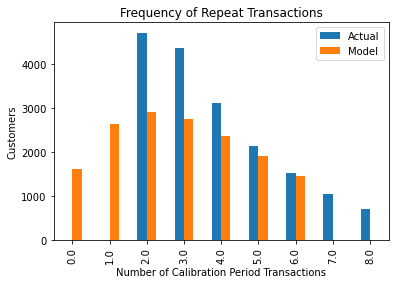

In [42]:
plot_period_transactions(bgf)
plt.show()

In [43]:
# Step 2: Fit the Gamma-Gamma model. Estimate the average value of the customers and add it to the cltv dataframe as exp_average_value

In [44]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [45]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 3.77, q: 0.82, v: 3.63>

In [46]:
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary_cltv_avg'])

In [47]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary_cltv_avg']).sort_values(ascending=False).head(10)

9055    1311.1112
6402     444.0374
16410    442.4433
1853     430.2932
12828    401.2775
14819    349.7120
16618    345.2605
794      329.9684
4087     325.3375
14694    315.7297
dtype: float64

In [48]:
cltv_df.head()

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,exp_sales_3,exp_sales_6,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2.4286,4.3878,5.0000,37.5748,6.9514,13.9026,38.6803
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,29.9796,32.1429,21.0000,4.5659,6.9293,13.8586,4.7499
2,69b69676-1a40-11ea-941b-000d3a38a36f,7.4694,11.2857,5.0000,23.4128,4.7251,9.4502,24.3782
3,1854e56c-491f-11eb-806e-000d3a38a36f,0.2245,3.0000,2.0000,30.4925,4.9627,9.9252,33.1201
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,11.8776,13.6531,2.0000,52.4950,2.7514,5.5028,55.6751


In [49]:
# Step 3: Calculate 6 months CLTV and add it to the dataframe with the name cltv
# Observe the 20 people with the highest cltv value

In [54]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)
cltv.head(20)

0    564.2246
1     69.0676
2    241.7181
3    344.9049
4    321.4503
5    133.8255
6    238.1988
7    334.4736
8    454.2621
9    255.4292
10   258.1786
11    80.0555
12   177.5983
13   280.5847
14   191.0742
15   175.1502
16   160.4839
17   441.4136
18   782.9575
19   474.7183
Name: clv, dtype: float64

In [65]:
cltv_df.sort_values("cltv", ascending=False).head(20)

KeyError: 'cltv'

# Task 4: Creating Segments by CLTV Value

In [66]:
# Step 1: Divide all your customers into 4 groups (segments) according to 6-month CLTV and add the group names to the dataset.

In [67]:
cltv["cltv_segment"] = pd.qcut(cltv["cltv"], 4, labels=["D", "C", "B", "A"])
cltv.head(25)

KeyError: 'cltv'

In [ ]:
def create_cltv_df(dataframe):
    # Preparing Data
    columns = ["order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline","customer_value_total_ever_online"]
    for col in columns:
        replace_with_thresholds(dataframe, col)

    dataframe["order_num_total"] = dataframe["order_num_total_ever_online"] + dataframe["order_num_total_ever_offline"]
    dataframe["customer_value_total"] = dataframe["customer_value_total_ever_offline"] + dataframe["customer_value_total_ever_online"]
    dataframe = dataframe[~(dataframe["customer_value_total"] == 0) | (dataframe["order_num_total"] == 0)]
    date_columns = dataframe.columns[dataframe.columns.str.contains("date")]
    dataframe[date_columns] = dataframe[date_columns].apply(pd.to_datetime)

    # Creation of CLTV data structure
    dataframe["last_order_date"].max() # 2021-05-30
    today_date = dt.datetime(2021, 6, 1)
    cltv_df = pd.DataFrame()
    cltv_df["customer_id"] = dataframe["master_id"]
    cltv_df["recency_cltv_weekly"] = ((dataframe["last_order_date"] - dataframe["first_order_date"]).astype('timedelta64[D]')) / 7
    cltv_df["T_weekly"] = ((today_date - dataframe["first_order_date"]).astype('timedelta64[D]')) / 7
    cltv_df["frequency"] = dataframe["total_order"]
    cltv_df["monetary_cltv_avg"] = df["total_order"] / df["total_purchases"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

    # Establishment of BG-NBD Model
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency_cltv_weekly'],
            cltv_df['T_weekly'])
    cltv_df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])
    cltv_df["exp_sales_6_month"] = bgf.predict(4 * 6,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])

    # # Establishing the Gamma-Gamma Model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])
    cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                           cltv_df['monetary_cltv_avg'])

    # cltv forecast
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency_cltv_weekly'],
                                       cltv_df['T_weekly'],
                                       cltv_df['monetary_cltv_avg'],
                                       time=6,
                                       freq="W",
                                       discount_rate=0.01)
    cltv_df["cltv"] = cltv

    # CLTV segmentation
    cltv_df["cltv_segment"] = pd.qcut(cltv_df["cltv"], 4, labels=["D", "C", "B", "A"])

    return cltv_df
    
    
cltv_df = create_cltv_df(df)

cltv_df.head(10)
cltv_df.to_csv("flo_cltv_project2.csv")